# T02B - Fully Supervised Training with High-Level Features

In this notebook, we go through the fully supervised training of the LHCO AD datasets with high-level jet features.

## Step 1: Data Loading

- For the moment, data are loaded in memory instead of lazily.

In [1]:
import os
import awkward as ak
import tensorflow as tf

input_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_qq"
filenames = {
    "signal"           : os.path.join(input_dir, "col_based", "SR_point_cloud_W_qq_500_100_official.parquet"),
    "background"       : os.path.join(input_dir, "col_based", "SR_point_cloud_QCD_qq.parquet"),
    "extra_background" : os.path.join(input_dir, "col_based", "SR_point_cloud_extra_QCD_qq.parquet"),
}

2023-11-15 13:56:31.937541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Check software version

In [2]:
print(f'awkward version     : {ak.__version__}')
print(f'tensorflow version  : {tf.__version__}')

awkward version     : 2.4.6
tensorflow version  : 2.12.1


### Check GPU device

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Mon Nov 13 14:13:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   35C    P0    36W / 250W |   2418MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load high level data

In [5]:
from aliad.data import PointCloudDataset

In [6]:
feature_dict = {
        "jet_features"  : ["jet_pt", "jet_eta", "jet_phi", "jet_m", "N", "tau12", "tau23"]
}
class_labels = {
    0: ["background", "extra_background"],
    1: ["signal"],
}
## change your dataset sizes here
#sample_sizes = {
#    "background": 1000,
#    "signal"    :  100
#}
sample_sizes = None
dataset = PointCloudDataset(filenames, class_labels=class_labels, feature_dict=feature_dict,
                            sample_sizes=sample_sizes, shuffle=False)

[INFO] Loading dataset from "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_qq/col_based/SR_point_cloud_QCD_qq.parquet"
[INFO] Preparing data for the sample "background" (class = 0)
[INFO] Size of sample data: 121351
[INFO] Working on feature type "jet_features"
[INFO] Jet index: 1
[INFO] Loading data for the feature "jet_pt"
[INFO] Loading data for the feature "jet_eta"
[INFO] Loading data for the feature "jet_phi"
[INFO] Loading data for the feature "jet_m"
[INFO] Loading data for the feature "N"
[INFO] Loading data for the feature "tau12"
[INFO] Loading data for the feature "tau23"
[INFO] Jet index: 2
[INFO] Loading data for the feature "jet_pt"
[INFO] Loading data for the feature "jet_eta"
[INFO] Loading data for the feature "jet_phi"
[INFO] Loading data for the feature "jet_m"
[INFO] Loading data for the feature "N"
[INFO] Loading data for the feature "tau12"
[INFO] Loading data for the feature "tau23"
[INFO] Loading dataset from "/pscratch/sd/c/chlcheng/

In [7]:
# jet features for the first jet in the first event
print("Particle coordinates for the first jet for the first event\n")
print(f"Shape : {dataset.X['jet_features'][0][0].shape} = (nparticles, njetfeatures) ")
print(f"Data  : {dataset.X['jet_features'][0][0]}")

Particle coordinates for the first jet for the first event

Shape : (7,) = (nparticles, njetfeatures) 
Data  : [ 1.55725584 -0.28612276 -0.44800308  0.23789407 29.          0.26323715
  0.7975898 ]


### Create train-validation-test splits

In [8]:
from aliad.data import split_dataset
from aliad.utils.system_utils import print_memory_usage

In [9]:
dataset_split = split_dataset(dataset.X, dataset.y, val_size=0.25, test_size=0.25, shuffle=True, random_state=2023)

In [10]:
print_memory_usage(dataset_split)

X_train:
    jet_features: 43.23 MB
X_val:
    jet_features: 21.62 MB
X_test:
    jet_features: 21.62 MB
y_train: 3.09 MB
y_val: 1.54 MB
y_test: 1.54 MB
Total Memory Usage: 92.64 MB


97140120

### Prepare dataset in tensorflow.data.Dataset format

In [11]:
from aliad.interface.tensorflow.dataset import prepare_dataset
batch_size = 1024
train_ds = prepare_dataset(dataset_split['X_train']['jet_features'],
                           y=dataset_split['y_train'],
                           batch_size=batch_size,
                           shuffle=True,
                           # can't set too high buffer size due to memory constraint
                           buffer_size=1024,
                           seed=2023)
val_ds = prepare_dataset(dataset_split['X_val']['jet_features'],
                         y=dataset_split['y_val'],
                         batch_size=batch_size,
                         shuffle=False)
test_ds = prepare_dataset(dataset_split['X_test']['jet_features'],
                          y=dataset_split['y_test'],
                          batch_size=batch_size,
                          shuffle=False)

2023-11-13 14:13:50.538862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35803 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


## Step 2: Create simple MLP model

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
model = Sequential([
    Input(shape=dataset_split['X_train']['jet_features'].shape[1:]),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [13]:
steps_per_epoch = dataset_split['y_train'].shape[0] / batch_size
config = {
    # for binary classification
    'loss'       : 'binary_crossentropy',
    'metrics'    : ['accuracy'],
    'epochs'     : 100,
    'optimizer'  : 'Adam',
    'optimizer_config': {
        'learning_rate': 0.001
    },
    'checkpoint_dir': '/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/'
                      'high_level_full_dataset_SR_v1',
    'callbacks': {
        'lr_scheduler': {
            'initial_lr': 0.001,
            'lr_decay_factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6
        },
        'early_stopping': {
            'monitor': 'val_loss',
            'patience': 3
        },
        'model_checkpoint':{
            'save_weights_only': True,
            # save model checkpoint every epoch
            'save_freq': int(steps_per_epoch * 1)
        }
    }
}

In [14]:
optimizer = tf.keras.optimizers.get({'class_name': config['optimizer'], 'config': config['optimizer_config']})
model.compile(loss=config['loss'],
              optimizer=optimizer,
              metrics=config['metrics'])

### Prepare callbacks

In [15]:
from aliad.interface.tensorflow.callbacks import LearningRateScheduler, BatchMetricsCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = config['checkpoint_dir']
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

lr_scheduler = LearningRateScheduler(**config['callbacks']['lr_scheduler'])

early_stopping = EarlyStopping(**config['callbacks']['early_stopping'])

checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_weights_epoch_{epoch:02d}.h5'),
                             **config['callbacks']['model_checkpoint'])
batch_metrics = BatchMetricsCallback()
callbacks = [lr_scheduler, early_stopping, checkpoint, batch_metrics]

### Show model summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 256)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 45,057
Trainable params: 45,057
Non-trainable params: 0
_________________________________________________________________


## Step 3: Train Model

In [17]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=config['epochs'],
          callbacks=callbacks)

Epoch 1/100


2023-11-13 14:13:53.769367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [404751,2,7]
	 [[{{node Placeholder/_0}}]]
2023-11-13 14:13:53.769850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [404751,1]
	 [[{{node Placeholder/_1}}]]


 63/395 [===>..........................] - ETA: 0s - loss: 0.3330 - accuracy: 0.8973 

2023-11-13 14:13:57.025070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


395/395 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9201

2023-11-13 14:13:57.848285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [202375,1]
	 [[{{node Placeholder/_1}}]]


395/395 [==============================] - 4s 3ms/step - loss: 0.2250 - accuracy: 0.9201 - val_loss: 0.1489 - val_accuracy: 0.9414
Epoch 2/100
395/395 [==============================] - 1s 2ms/step - loss: 0.1405 - accuracy: 0.9464 - val_loss: 0.1351 - val_accuracy: 0.9487
Epoch 3/100
395/395 [==============================] - 1s 2ms/step - loss: 0.1326 - accuracy: 0.9505 - val_loss: 0.1340 - val_accuracy: 0.9496
Epoch 4/100
395/395 [==============================] - 1s 2ms/step - loss: 0.1300 - accuracy: 0.9518 - val_loss: 0.1340 - val_accuracy: 0.9502
Epoch 5/100
395/395 [==============================] - 1s 2ms/step - loss: 0.1259 - accuracy: 0.9535 - val_loss: 0.1244 - val_accuracy: 0.9541
Epoch 6/100
395/395 [==============================] - 1s 3ms/step - loss: 0.1235 - accuracy: 0.9548 - val_loss: 0.1209 - val_accuracy: 0.9560
Epoch 7/100
395/395 [==============================] - 1s 2ms/step - loss: 0.1237 - accuracy: 0.9546 - val_loss: 0.1182 - val_accuracy: 0.9573
Epoch 8/100

### Save model output

In [18]:
# save entire model
filename = os.path.join(config['checkpoint_dir'], "full_train_100_epoch.keras")
model.save(filename)

In [19]:
# save metrics history from training and evaluation
import json
metrics_history = {
    "train": batch_metrics.batch_train_metrics,
    "val": batch_metrics.batch_val_metrics,
}
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
json.dump(metrics_history, open(filename, "w"))

## Model Testing

In [20]:
filename = os.path.join(config['checkpoint_dir'], "full_train_100_epoch.keras")
model = tf.keras.models.load_model(filename)

In [21]:
predicted_proba = model.predict(test_ds)

107/197 [===============>..............] - ETA: 0s

2023-11-13 14:14:40.531761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [202375,1]
	 [[{{node Placeholder/_1}}]]


197/197 [==============================] - 0s 947us/step


In [22]:
import numpy as np
y_pred = np.round(predicted_proba.flatten())
y_true = np.array([y for (x, y) in test_ds]).flatten()

In [23]:
accuracy = np.mean(y_true.flatten() == y_pred.flatten())
accuracy

0.972512492068528

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
fpr, tpr, _ = roc_curve(y_true, predicted_proba.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9823262019983949

### Evaluate Error from Bootstrapping

In [25]:
def get_bootstrap_prediction(y_pred, y_true, num_bootstrap_samples:int=20,
                             seed:int=2023):
    np.random.seed(seed)
    bootstrap_predictions = []
    bootstrap_truths = []
    sample_size = y_pred.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        bootstrap_indices = np.random.choice(sample_size, sample_size, replace=True)
        bootstrap_y_pred = y_pred[bootstrap_indices]
        bootstrap_y_true = y_true[bootstrap_indices]
        bootstrap_predictions.append(bootstrap_y_pred)
        bootstrap_truths.append(bootstrap_y_true)
    bootstrap_predictions = np.array(bootstrap_predictions)
    bootstrap_truths = np.array(bootstrap_truths)
    return bootstrap_predictions, bootstrap_truths

In [26]:
num_bootstrap_samples = 100
bootstrap_predictions, bootstrap_truths = get_bootstrap_prediction(predicted_proba.flatten(),
                                                                   y_true,
                                                                   num_bootstrap_samples=num_bootstrap_samples,
                                                                   seed=2023)

In [27]:
bootstrap_y_pred = np.round(bootstrap_predictions)

In [28]:
bootstrap_accuracy = np.mean(bootstrap_y_pred == bootstrap_truths, axis=1)
bootstrap_fpr, bootstrap_tpr, bootstrap_auc = [], [], []
for i in range(num_bootstrap_samples):
    bs_fpr, bs_tpr, _ = roc_curve(bootstrap_truths[i], bootstrap_predictions[i])
    bs_roc_auc = auc(bs_fpr, bs_tpr)
    bootstrap_fpr.append(bs_fpr)
    bootstrap_tpr.append(bs_tpr)
    bootstrap_auc.append(bs_roc_auc)
bootstrap_auc = np.array(bootstrap_auc)

In [29]:
from scipy.interpolate import interp1d
def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=1000, mean=False):

    # interpolation
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs_list:
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tpr_manual = np.linspace(max_min_tpr, min_max_tpr, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        roc_function = interp1d(tpr, 1/(fpr+1e-3))
        sic_function = interp1d(tpr, tpr/((fpr+1e-3)**(0.5)))
        roc_interpol.append(roc_function(tpr_manual))
        sic_interpol.append(sic_function(tpr_manual))
                     
    # calculating mean+std or median+quantiles
    if mean:
        roc_median = np.mean(np.stack(roc_interpol), axis=0)
        sic_median = np.mean(np.stack(sic_interpol), axis=0)
        roc_std = np.std(np.stack(roc_interpol), axis=0)
        sic_std = np.std(np.stack(sic_interpol), axis=0)
        roc_std = (roc_median-roc_std, roc_median+roc_std)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        roc_median = np.median(np.stack(roc_interpol), axis=0)
        sic_median = np.median(np.stack(sic_interpol), axis=0)
        roc_std = (np.quantile(np.stack(roc_interpol), 0.16, axis=0), np.quantile(np.stack(roc_interpol), 0.84, axis=0))
        sic_std = (np.quantile(np.stack(sic_interpol), 0.16, axis=0), np.quantile(np.stack(sic_interpol), 0.84, axis=0))
    
    return tpr_manual, roc_median, sic_median, roc_std, sic_std

In [30]:
tpr_manual, roc_median, _, roc_std, _ = compute_median_and_variance_roc_sic(bootstrap_tpr,
                                                                            bootstrap_fpr)

### Save test outputs

In [31]:
from quickstats.utils.common_utils import NpEncoder
import numpy as np
import json
results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'accuracy': accuracy,
    'auc': roc_auc,
    'tpr': tpr,
    'fpr': fpr,
    'bootstrap_predicted_proba': bootstrap_predictions,
    'bootstrap_y_true': bootstrap_truths,
    'bootstrap_y_pred': bootstrap_y_pred,
    'bootstrap_tpr': bootstrap_tpr,
    'bootstrap_fpr': bootstrap_fpr,
    'bootstrap_accuracy': bootstrap_accuracy,
    'bootstrap_auc': bootstrap_auc,
    'tpr_manual': tpr_manual,
    'roc_median': roc_median,
    'roc_std': roc_std
}
filename = os.path.join(config['checkpoint_dir'], "test_results.json")
json.dump(results, open(filename, "w"), cls=NpEncoder)

In [32]:
# load back test results
import numpy as np
import json
filename = os.path.join(config['checkpoint_dir'], "test_results.json")
results = json.load(open(filename, 'r'))
for key in results:
    if 'bootstrap' in key:
        continue
    results[key] = np.array(results[key])
predicted_proba = results['predicted_proba']
y_pred = results['y_pred']
y_true = results['y_true']
roc_auc = results['auc']
tpr = results['tpr']
fpr = results['fpr']
tpr_manual = results['tpr_manual']
roc_median = results['roc_median']
roc_std = results['roc_std']

## Visualization

### Loss, Accuracy Curves

In [33]:
import json
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
metrics_history = json.load(open(filename))
num_epochs = 13
dfs = {}
for key, value in metrics_history.items():
    dfs[key] = pd.DataFrame(value)
    steps_per_epoch = dfs[key].shape[0] // num_epochs
    dfs[key]['epoch'] = (dfs[key].index + 1) / steps_per_epoch

In [34]:
from quickstats.plots import General1DPlot
label_map = {
    'train': 'Train',
    'val': 'Validation'
}
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.1, 0.8),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with High Level Features'
}
styles = {
    'legend': {
        'loc': (0.7, 0.7)
    }
}
plotter = General1DPlot(dfs, color_cycle='checker',
                        label_map=label_map, styles=styles,
                        analysis_label_options=analysis_label_options)

<Axes: xlabel='Epoch', ylabel='Loss'>

<Figure size 640x480 with 0 Axes>

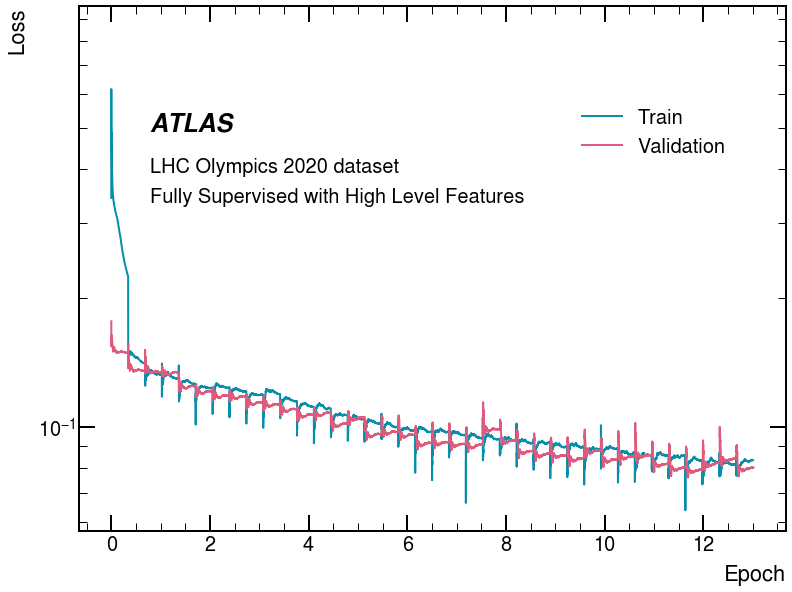

In [35]:
plotter.draw('epoch', 'loss', logy=True, xlabel='Epoch', ylabel='Loss')

<Axes: xlabel='Epoch', ylabel='Accuracy'>

<Figure size 640x480 with 0 Axes>

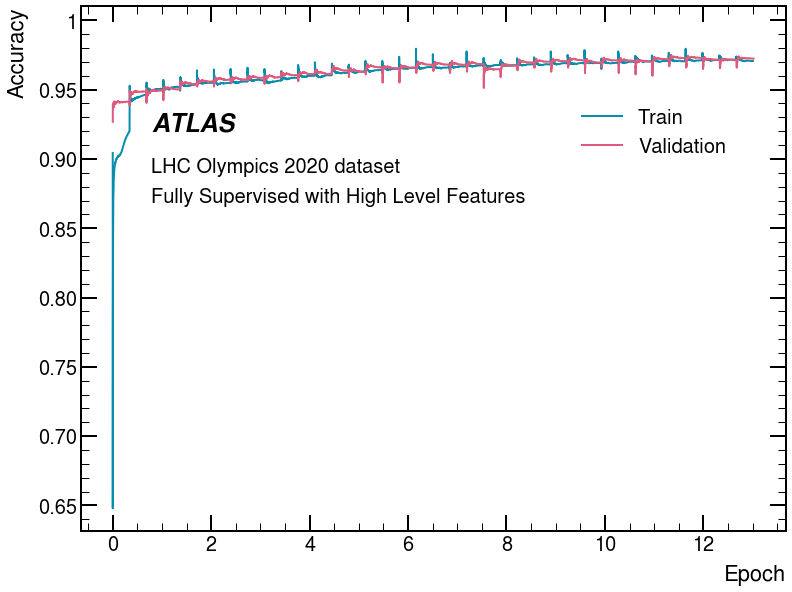

In [36]:
plotter.draw('epoch', 'accuracy', xlabel='Epoch', ylabel='Accuracy', ymax=1.01)

### model output (score) distribution

In [37]:
sig_mask = y_true == 1
bkg_mask = y_true == 0
dfs = {
    'Signal'     : pd.DataFrame({"score": predicted_proba.flatten()[sig_mask]}),
    'Background' : pd.DataFrame({"score": predicted_proba.flatten()[bkg_mask]})
}

In [38]:
from quickstats.plots import VariableDistributionPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.12, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with High Level Features'
}
styles = {
    'legend': {
        'loc': (0.65, 0.8)
    }
}
plotter = VariableDistributionPlot(dfs, color_cycle='checker',
                                   styles=styles, analysis_label_options=analysis_label_options)

<Axes: xlabel='Predicted Prob.', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

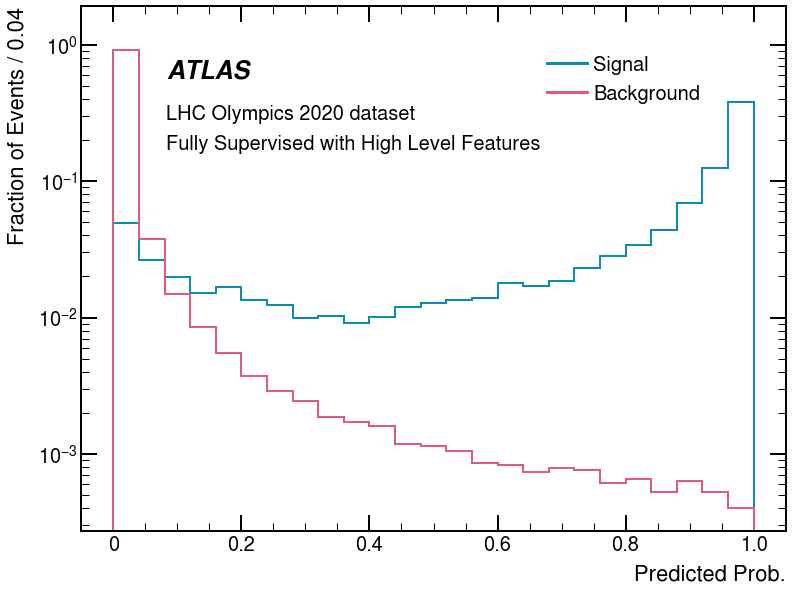

In [39]:
plotter.draw('score', xlabel='Predicted Prob.', bin_range=(0, 1), logy=True)

### AUC Curve

In [40]:
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.05, 0.75),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with High Level Features//AUC = {roc_auc:.3f}'
}
df = pd.DataFrame({"fpr_inv": roc_median, "tpr": tpr_manual})
plotter = General1DPlot(df, color_cycle=['rust'],
                        analysis_label_options=analysis_label_options)

<Figure size 640x480 with 0 Axes>

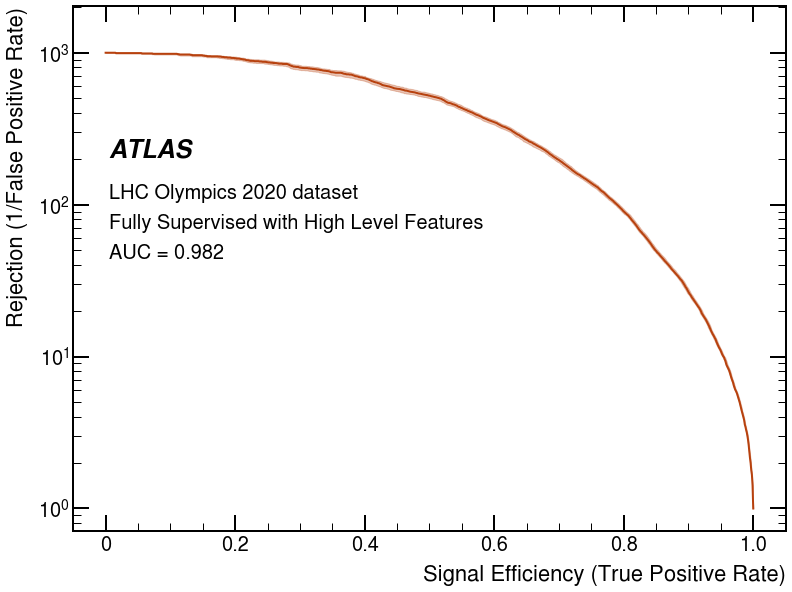

In [41]:
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)")
ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)

## Comparison with low-level results

In [42]:
import os
test_results = {}
basedir = "/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised"
checkpoint_paths = {
    'low-level': os.path.join(basedir, "low_level_full_dataset_SR_v1"),
    'high-level': os.path.join(basedir, "high_level_full_dataset_SR_v1"),
}
for scenario in checkpoint_paths:
    filename = os.path.join(checkpoint_paths[scenario], 'test_results.json')
    test_results[scenario] = json.load(open(filename))

In [43]:
from quickstats.plots import General1DPlot
label_map = {
    'low-level': f"Low-level (AUC = {test_results['low-level']['auc']:.3f})",
    'high-level': f"High-level (AUC = {test_results['high-level']['auc']:.3f})"
}
dfs = {}
for scenario in test_results:
    df = pd.DataFrame({"fpr_inv": test_results[scenario]['roc_median'],
                       "tpr": test_results[scenario]['tpr_manual']})
    dfs[scenario] = df
styles = {
    'legend': {
        'loc': (0.05, 0.7)
    }
}
plotter = General1DPlot(dfs, color_cycle=['hh:darkpink', 'hh:medturquoise'], label_map=label_map, styles=styles)

<Figure size 640x480 with 0 Axes>

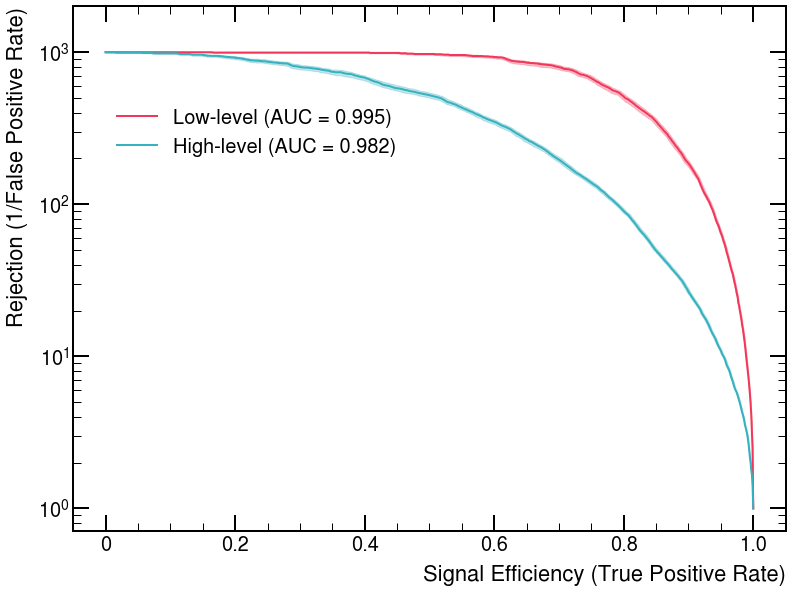

In [44]:
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)",
                  ymax=2e3)
for scenario, color in [['low-level', 'hh:darkpink'], ['high-level', 'hh:medturquoise']]:
    ax.fill_between(test_results[scenario]['tpr_manual'],
                    test_results[scenario]['roc_std'][0],
                    test_results[scenario]['roc_std'][1],
                    color=color, alpha=0.3)